In [1]:
from tslearn.metrics import dtw_path
from utils import *
from keypoint_frames import *
from overall_video_similarity import *
from settings import *
from clustering import *
from visualization import display_video

In [2]:
import os
import re
import pandas as pd

In [3]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [4]:
video_names = list_video_names() # in utils.py
video_names = [x for x in video_names if 'P2'!=x]

In [6]:
len(video_names)

84

In [7]:
# Create angle DataFrames for each video
angle_dataframes = {}
for video_name in video_names[:5]:
    angle_dataframes[video_name] = create_angles(video_name)  # Or use create_angles_new() => DanceMoves function

In [8]:
angle_dataframes[video_name].shape # (winkel, n_frames)

(29, 71)

In [9]:
angle_dataframes[video_name] # 1 Video => (29 winkel = Rows, (?)84 Frames = Columns)

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.145,0.145,0.145,0.201,0.145,0.144,0.141,0.115,0.144,0.113,...,0.234,0.231,0.202,0.183,0.157,0.180,0.225,0.228,0.252,0.252
1,-0.194,-0.194,-0.193,-0.145,-0.193,-0.193,-0.199,-0.120,-0.146,-0.119,...,-0.189,-0.186,-0.164,-0.228,-0.209,-0.233,-0.229,-0.232,-0.256,-0.212
2,-0.999,-0.999,-0.999,-0.998,-0.999,-0.999,-0.998,-1.000,-1.000,-1.000,...,-0.999,-0.999,-0.999,-0.999,-0.999,-0.999,-1.000,-1.000,-1.000,-0.999
3,0.638,0.638,0.638,0.680,0.650,0.649,0.631,0.635,0.636,0.616,...,0.985,0.985,0.985,0.976,0.974,0.974,0.989,0.990,0.988,0.991
4,0.432,0.431,0.444,0.431,0.431,0.443,0.462,0.445,0.471,0.572,...,0.976,0.976,0.976,0.970,0.969,0.969,0.970,0.965,0.962,0.975
5,0.487,0.487,0.487,0.548,0.505,0.488,0.500,0.547,0.547,0.534,...,0.982,0.983,0.983,0.990,0.991,0.991,0.989,0.989,0.989,0.976
6,0.325,0.304,0.325,0.286,0.285,0.325,0.268,0.285,0.284,0.294,...,0.761,0.757,0.758,0.758,0.758,0.773,0.777,0.777,0.777,0.792
7,0.217,0.217,0.216,0.216,0.217,0.215,0.295,0.166,0.292,0.162,...,0.414,0.519,0.520,0.519,0.441,0.532,0.519,0.384,0.448,0.413
8,-0.531,-0.531,-0.531,-0.529,-0.531,-0.531,-0.532,-0.657,-0.534,-0.663,...,-0.315,-0.242,-0.266,-0.245,-0.270,-0.192,-0.245,-0.386,-0.296,-0.297
9,-0.461,-0.461,-0.461,-0.590,-0.589,-0.589,-0.589,-0.567,-0.588,-0.565,...,-0.925,-0.898,-0.908,-0.898,-0.909,-0.763,-0.897,-0.925,-0.813,-0.814


# Introduction: Dynamic Time Warping (alingment)

1. Initialize a cost matrix C of size (n+1) x (m+1) with zeros, where n and m are the lengths of time series A and B, respectively.
2. Set C[0][0] to infinity.
3. For each element (i, j) in C, excluding C[0][0]:
   a. Calculate the squared Euclidean distance d(i, j) between A[i-1] and B[j-1].
   b. Update the cost matrix C[i][j] with the sum of d(i, j) and the minimum of the neighboring costs:
      C[i-1][j], C[i][j-1], and C[i-1][j-1].
4. Initialize an empty list to store the DTW path.
5. Set the current position (i, j) to (n, m).
6. While i > 0 or j > 0:
   a. Append the current position (i, j) to the DTW path.
   b. Find the neighboring cell (i', j') with the minimum cost:
      C[i-1][j], C[i][j-1], and C[i-1][j-1].
   c. Update the current position (i, j) to (i', j').
7. Append the starting position (0, 0) to the DTW path.
8. Reverse the DTW path.
9. Return the DTW path.


In [10]:
for video_name in video_names:
    if video_name in angle_dataframes.keys():
        df = angle_dataframes[video_name]
        nan_rows_indices = df[df.isna().any(axis=1)].index.tolist()
        if len(nan_rows_indices) > 0:
            print(nan_rows_indices)
            
# wir scchauen ob irgendwo openpose nan values hat / keine angles available

[22, 23]


In [11]:
from utils import angle_ids_to_angles
from overall_video_similarity import *

In [12]:
video_names = video_names[:10]

In [14]:
# Calculate overall similarity for each pair of videos in the list
similarities = {}
for i in range(len(video_names)):
    for j in range(i+1, len(video_names)):
        if i != j:
            video_a = video_names[i]
            video_b = video_names[j]
            print('Calculating similarities between {} and {}.'.format(video_a, video_b))
            angles_a = angle_dataframes[video_a].fillna(0)  # angle table of video 1
            angles_b = angle_dataframes[video_b].fillna(0)  # angle table of video 2
            similarity, path_dict = overall_similarity(angles_a, angles_b)  # dtw (vertical)
            similarities[(video_a, video_b)] = similarity
            print()

Calculating similarities between AR and AS_L_NA.

Calculating similarities between AR and AS_L_WA.

Calculating similarities between AR and BA_R_NA.

Calculating similarities between AR and BA_R_WA.

Calculating similarities between AR and BBS_F_BK.


KeyError: 'BBS_F_BK'

In [15]:
# um den pfad von up2 und up3 zu veranschaulichen kann man path_dict ausprinten

In [16]:
similarities

{('AR', 'AS_L_NA'): 0.817,
 ('AR', 'AS_L_WA'): 0.808,
 ('AR', 'BA_R_NA'): 0.837,
 ('AR', 'BA_R_WA'): 0.857}

In [17]:
# Hier vergleiche ich 2 videos miteinander (a und b)
video_a = video_names[0]
video_b = video_names[1]
print('Calculating similarities between {} and {}.'.format(video_a, video_b))
angles_a = angle_dataframes[video_a].fillna(0)
angles_b = angle_dataframes[video_b].fillna(0)
print(angles_a.shape)
print(angles_b.shape)
path, cost = dtw_path(angles_a.T, angles_b.T)

Calculating similarities between AR and AS_L_NA.
(29, 50)
(29, 64)


In [18]:
video_a

'AR'

In [19]:
video_b

'AS_L_NA'

In [20]:
display_video(video_a)

In [21]:
BODYPARTS_POINT

['Nose',
 'Neck',
 'Right Shoulder',
 'Right Elbow',
 'Right Wrist',
 'Left Shoulder',
 'Left Elbow',
 'Left Wrist',
 'MidHip',
 'Right Hip',
 'Right Knee',
 'Right Ankle',
 'Left Hip',
 'Left Knee',
 'Left Ankle',
 'Right Eye',
 'Left Eye',
 'Right Ear',
 'Left Ear',
 'Left BigToe',
 'Left SmallToe',
 'Left Heel',
 'Right BigToe',
 'Right SmallToe',
 'Right Heel']

In [22]:
BODY_SEGMENTS

{'torso': [1, 8],
 'right_shoulder': [1, 2],
 'right_upper_arm': [2, 3],
 'right_lower_arm': [3, 4],
 'left_shoulder': [1, 5],
 'left_upper_arm': [5, 6],
 'left_lower_arm': [6, 7],
 'right_hip': [8, 9],
 'right_upper_leg': [9, 10],
 'right_lower_leg': [10, 11],
 'left_hip': [8, 12],
 'left_upper_leg': [12, 13],
 'left_lower_leg': [13, 14],
 'nose_to_neck': [1, 0],
 'right_eye_to_nose': [0, 15],
 'right_ear_to_eye': [15, 17],
 'left_eye_to_nose': [0, 16],
 'left_ear_to_eye': [16, 18],
 'left_foot': [14, 19],
 'left_toes': [19, 20],
 'left_ankle_to_heel': [14, 21],
 'right_foot': [11, 22],
 'right_toes': [22, 23],
 'right_ankle_to_heel': [11, 24]}

In [23]:
BODYPART_INDEX

{0: 'nose_to_neck_to_left_shoulder',
 1: 'nose_to_neck_to_right_shoulder',
 2: 'left_shoulder_to_right_shoulder',
 3: 'left_shoulder_to_left_upper_arm',
 4: 'left_lower_arm_to_left_upper_arm',
 5: 'right_upper_arm_to_right_shoulder',
 6: 'right_upper_arm_to_right_lower_arm',
 7: 'left_eye_to_nose_to_left_ear_to_eye',
 8: 'left_eye_to_nose_to_neck',
 9: 'nose_to_neck_to_right_eye_to_nose',
 10: 'left_eye_to_nose_to_right_eye_to_nose',
 11: 'right_eye_to_nose_to_right_ear_to_eye',
 12: 'right_hip_to_right_upper_leg',
 13: 'right_upper_leg_to_right_lower_leg',
 14: 'left_hip_to_left_upper_leg',
 15: 'left_upper_leg_to_left_lower_leg',
 16: 'left_lower_leg_left_ankle_to_heel',
 17: 'right_lower_leg_to_right_ankle_to_heel',
 18: 'right_foot_to_right_toes',
 19: 'right_foot_to_right_lower_leg',
 20: 'right_foot_to_right_ankle_to_heel',
 21: 'left_foot_to_left_lower_leg',
 22: 'left_foot_to_left_ankle_to_heel',
 23: 'left_foot_to_left_toes',
 24: 'torso_to_right_shoulder',
 25: 'torso_to_left

In [24]:
display_video(video_b)

# Advanced Problem Statement

Ich wollte mich noch etwas eingehender mit DTW und similarities auseinander setzen.

Given a long time series representing movements in a video and a shorter query time series representing a specific movement pattern, find the most similar local segment in the long time series using Dynamic Time Warping (DTW).

Ich benutze nur diagonal elemente (die cosine similarity values) um zu verhindern dass der mean von nicht-align-ten frames verfälscht wird.

## Objective

The objective is to identify the local segment in the long time series that best matches the query time series in terms of their movement patterns.

Ich filtere den DTW path um die relevanten Segmente genauer zu analysieren, nicht die gesamten Videos.

In [25]:
def get_aligned_segments(path, min_segment_length=10):
    aligned_segments = []
    current_segment = []

    for i in range(1, len(path)):
        # Prüfe ob es ein diagonal element ist, in diesem Fall ist es ein aligned segment
        if path[i][0] > path[i-1][0] and path[i][1] > path[i-1][1]:
            current_segment.append(path[i])
        else:
            if len(current_segment) >= min_segment_length:
                aligned_segments.append(current_segment)
            current_segment = []

    if len(current_segment) >= min_segment_length:
        aligned_segments.append(current_segment)
        
    return [pair for sublist in aligned_segments for pair in sublist]

def aligned_segement_similarity(X_angles, Y_angles, min_segment_length=5):
    # Input sind die angles von video 1 und video 2, min segement sagt wie gross die mindestläng ist
    similar_num = 0
    cos_vector = np.array([])
    path, cost = dtw_path(X_angles.T, Y_angles.T)
    path = get_aligned_segments(path, min_segment_length)
    
    path_dict = dict()
    for f1, f2 in path:
        path_dict.setdefault(f1, []).append(f2)
    # Im grunde löscht man alles aus dem pfad was nicht diagonal ist und mindestlänge hat
    for i, j in path:
        a = cosine_similarity(X_angles[i].values.reshape(1, -1), Y_angles[j].values.reshape(1, -1))
        if a != (np.array([0])):
            cos_vector = np.append(cos_vector, a)
            
    similar_num = round(np.mean(cos_vector), 3)
    
    return similar_num, path

In [26]:
similarity, aligned_segment_path = aligned_segement_similarity(angles_a, angles_b, 5)

In [27]:
similarity

0.833

Achtung! Die resultierende Similarity ist optimistischer als der standard dtw path !

# Results

In [28]:
video_names = list_video_names()
video_names = [x for x in video_names if 'P2'!=x]

In [29]:
len(video_names)

84

In [30]:
# Lade OpenPoses und berechne winkel, speichere diese für alle videos in einem dict
angle_dataframes = {}
for video_name in tqdm(video_names):
    try:
        angles = create_angles(video_name)
        angle_dataframes[video_name] = angles.fillna(0)
    except:
        print("Could not process {}.".format(video_name))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [01:10<00:00,  1.19it/s]


## Global alignment similarity (See DanceMoves)

Stardard Similarity DTW mit Cosine Similarity

In [31]:
n_tot = int((len(video_names)**2 - len(video_names)) / 2)
i = 0

similarities1 = pd.DataFrame(index=video_names, columns=video_names)

for a, video_a in enumerate(video_names):
    for b, video_b in enumerate(video_names):
        if (video_a in angle_dataframes.keys()) & (video_b in angle_dataframes.keys()):
            if (a != b):
                if (a < b):
                    angles_a = angle_dataframes[video_a]
                    angles_b = angle_dataframes[video_b]
                    similarity, _ = overall_similarity(angles_a, angles_b)
                    similarities1.loc[video_a, video_b] = similarity
            else:
                similarity = 1
                similarities1.loc[video_a, video_b] = similarity

            print("{}/{} \t {} x {} => {}".format(i, n_tot, video_a, video_b, similarity))
            i += 1

        
for a, video_a in enumerate(video_names):
    for b, video_b in enumerate(video_names):
        if (a != b) & (video_a in angle_dataframes.keys()) & (video_b in angle_dataframes.keys()):
            if (a > b):
                similarities1.loc[video_a, video_b] = similarities1.loc[video_b, video_a]

0/3486 	 AR x AR => 1
1/3486 	 AR x AS_L_NA => 0.817
2/3486 	 AR x AS_L_WA => 0.808
3/3486 	 AR x BA_R_NA => 0.837
4/3486 	 AR x BA_R_WA => 0.857
5/3486 	 AR x BBS_F_BK => 0.683
6/3486 	 AR x BBS_F_FT => 0.653
7/3486 	 AR x BBS_S_BK => 0.659
8/3486 	 AR x BBS_S_FT => 0.66
9/3486 	 AR x BJ_BK => 0.834
10/3486 	 AR x BJ_FT => 0.692
11/3486 	 AR x BJ_LT => 0.835
12/3486 	 AR x BJ_RT => 0.808
13/3486 	 AR x BSS_F_BK => 0.719
14/3486 	 AR x BSS_F_FT => 0.67
15/3486 	 AR x BSS_S_BK => 0.656
16/3486 	 AR x BSS_S_FT => 0.647
17/3486 	 AR x BS_F_BK => 0.725
18/3486 	 AR x BS_F_FT => 0.717
19/3486 	 AR x BS_F_LT => 0.845
20/3486 	 AR x BS_F_RT => 0.802
21/3486 	 AR x BS_S_BK => 0.74
22/3486 	 AR x BS_S_FT => 0.738
23/3486 	 AR x BS_S_LT => 0.839
24/3486 	 AR x BS_S_RT => 0.801
25/3486 	 AR x CH => 0.763
26/3486 	 AR x CU_R_NA => 0.796
27/3486 	 AR x CU_R_WA => 0.835
28/3486 	 AR x EF => 0.8
29/3486 	 AR x FR_R_NA => 0.784
30/3486 	 AR x FR_R_WA => 0.867
31/3486 	 AR x LD_F_dis => 0.91
32/3486 	 

238/3486 	 AS_L_WA x TB_F_FB => 0.742
239/3486 	 AS_L_WA x TB_S => 0.759
240/3486 	 AS_L_WA x TB_S_FB => 0.73
241/3486 	 AS_L_WA x TF_F => 0.818
242/3486 	 AS_L_WA x TF_S => 0.846
243/3486 	 AS_L_WA x TL_F => 0.797
244/3486 	 AS_L_WA x TL_S => 0.781
245/3486 	 AS_L_WA x TOS_F => 0.843
246/3486 	 AS_L_WA x TOS_S => 0.822
247/3486 	 AS_L_WA x TR_F => 0.811
248/3486 	 AS_L_WA x TR_S => 0.883
249/3486 	 AS_L_WA x UP1 => 0.686
250/3486 	 AS_L_WA x UP2 => 0.698
251/3486 	 AS_L_WA x UP3 => 0.69
252/3486 	 BA_R_NA x AR => 0.69
253/3486 	 BA_R_NA x AS_L_NA => 0.69
254/3486 	 BA_R_NA x AS_L_WA => 0.69
255/3486 	 BA_R_NA x BA_R_NA => 1
256/3486 	 BA_R_NA x BA_R_WA => 0.94
257/3486 	 BA_R_NA x BBS_F_BK => 0.652
258/3486 	 BA_R_NA x BBS_F_FT => 0.669
259/3486 	 BA_R_NA x BBS_S_BK => 0.623
260/3486 	 BA_R_NA x BBS_S_FT => 0.644
261/3486 	 BA_R_NA x BJ_BK => 0.817
262/3486 	 BA_R_NA x BJ_FT => 0.765
263/3486 	 BA_R_NA x BJ_LT => 0.84
264/3486 	 BA_R_NA x BJ_RT => 0.792
265/3486 	 BA_R_NA x BSS_F_BK =

460/3486 	 BBS_F_BK x P3 => 0.517
461/3486 	 BBS_F_BK x PB_F => 0.699
462/3486 	 BBS_F_BK x PB_S => 0.731
463/3486 	 BBS_F_BK x PC_F => 0.616
464/3486 	 BBS_F_BK x PC_S => 0.618
465/3486 	 BBS_F_BK x PE => 0.51
466/3486 	 BBS_F_BK x PV_R_F => 0.72
467/3486 	 BBS_F_BK x PV_R_S => 0.766
468/3486 	 BBS_F_BK x RV_R_F => 0.707
469/3486 	 BBS_F_BK x RV_R_S => 0.718
470/3486 	 BBS_F_BK x SB_R_NA => 0.683
471/3486 	 BBS_F_BK x SB_R_WA => 0.697
472/3486 	 BBS_F_BK x SJ_BK => 0.734
473/3486 	 BBS_F_BK x SJ_FT => 0.732
474/3486 	 BBS_F_BK x SJ_LT => 0.676
475/3486 	 BBS_F_BK x SJ_RT => 0.757
476/3486 	 BBS_F_BK x SS_F_BK => 0.87
477/3486 	 BBS_F_BK x SS_F_FT => 0.878
478/3486 	 BBS_F_BK x SS_F_LT => 0.762
479/3486 	 BBS_F_BK x SS_F_RT => 0.783
480/3486 	 BBS_F_BK x SS_S_BK => 0.885
481/3486 	 BBS_F_BK x SS_S_FT => 0.885
482/3486 	 BBS_F_BK x SS_S_LT => 0.804
483/3486 	 BBS_F_BK x SS_S_RT => 0.817
484/3486 	 BBS_F_BK x SYN_B => 0.29
485/3486 	 BBS_F_BK x SYN_K => 0.641
486/3486 	 BBS_F_BK x SYN_R 

682/3486 	 BBS_S_FT x BJ_FT => 0.672
683/3486 	 BBS_S_FT x BJ_LT => 0.653
684/3486 	 BBS_S_FT x BJ_RT => 0.708
685/3486 	 BBS_S_FT x BSS_F_BK => 0.936
686/3486 	 BBS_S_FT x BSS_F_FT => 0.94
687/3486 	 BBS_S_FT x BSS_S_BK => 0.883
688/3486 	 BBS_S_FT x BSS_S_FT => 0.952
689/3486 	 BBS_S_FT x BS_F_BK => 0.815
690/3486 	 BBS_S_FT x BS_F_FT => 0.844
691/3486 	 BBS_S_FT x BS_F_LT => 0.765
692/3486 	 BBS_S_FT x BS_F_RT => 0.76
693/3486 	 BBS_S_FT x BS_S_BK => 0.859
694/3486 	 BBS_S_FT x BS_S_FT => 0.871
695/3486 	 BBS_S_FT x BS_S_LT => 0.758
696/3486 	 BBS_S_FT x BS_S_RT => 0.746
697/3486 	 BBS_S_FT x CH => 0.709
698/3486 	 BBS_S_FT x CU_R_NA => 0.704
699/3486 	 BBS_S_FT x CU_R_WA => 0.758
700/3486 	 BBS_S_FT x EF => 0.673
701/3486 	 BBS_S_FT x FR_R_NA => 0.669
702/3486 	 BBS_S_FT x FR_R_WA => 0.732
703/3486 	 BBS_S_FT x LD_F_dis => 0.723
704/3486 	 BBS_S_FT x LD_F_small => 0.72
705/3486 	 BBS_S_FT x LD_S_dis => 0.755
706/3486 	 BBS_S_FT x LD_S_small => 0.721
707/3486 	 BBS_S_FT x LU_F_big =

913/3486 	 BJ_FT x TF_F => 0.764
914/3486 	 BJ_FT x TF_S => 0.851
915/3486 	 BJ_FT x TL_F => 0.746
916/3486 	 BJ_FT x TL_S => 0.778
917/3486 	 BJ_FT x TOS_F => 0.754
918/3486 	 BJ_FT x TOS_S => 0.789
919/3486 	 BJ_FT x TR_F => 0.733
920/3486 	 BJ_FT x TR_S => 0.808
921/3486 	 BJ_FT x UP1 => 0.679
922/3486 	 BJ_FT x UP2 => 0.652
923/3486 	 BJ_FT x UP3 => 0.62
924/3486 	 BJ_LT x AR => 0.62
925/3486 	 BJ_LT x AS_L_NA => 0.62
926/3486 	 BJ_LT x AS_L_WA => 0.62
927/3486 	 BJ_LT x BA_R_NA => 0.62
928/3486 	 BJ_LT x BA_R_WA => 0.62
929/3486 	 BJ_LT x BBS_F_BK => 0.62
930/3486 	 BJ_LT x BBS_F_FT => 0.62
931/3486 	 BJ_LT x BBS_S_BK => 0.62
932/3486 	 BJ_LT x BBS_S_FT => 0.62
933/3486 	 BJ_LT x BJ_BK => 0.62
934/3486 	 BJ_LT x BJ_FT => 0.62
935/3486 	 BJ_LT x BJ_LT => 1
936/3486 	 BJ_LT x BJ_RT => 0.774
937/3486 	 BJ_LT x BSS_F_BK => 0.698
938/3486 	 BJ_LT x BSS_F_FT => 0.672
939/3486 	 BJ_LT x BSS_S_BK => 0.659
940/3486 	 BJ_LT x BSS_S_FT => 0.664
941/3486 	 BJ_LT x BS_F_BK => 0.81
942/3486 	 B

1143/3486 	 BSS_F_BK x SB_R_WA => 0.693
1144/3486 	 BSS_F_BK x SJ_BK => 0.748
1145/3486 	 BSS_F_BK x SJ_FT => 0.748
1146/3486 	 BSS_F_BK x SJ_LT => 0.687
1147/3486 	 BSS_F_BK x SJ_RT => 0.786
1148/3486 	 BSS_F_BK x SS_F_BK => 0.906
1149/3486 	 BSS_F_BK x SS_F_FT => 0.896
1150/3486 	 BSS_F_BK x SS_F_LT => 0.82
1151/3486 	 BSS_F_BK x SS_F_RT => 0.809
1152/3486 	 BSS_F_BK x SS_S_BK => 0.891
1153/3486 	 BSS_F_BK x SS_S_FT => 0.906
1154/3486 	 BSS_F_BK x SS_S_LT => 0.842
1155/3486 	 BSS_F_BK x SS_S_RT => 0.846
1156/3486 	 BSS_F_BK x SYN_B => 0.398
1157/3486 	 BSS_F_BK x SYN_K => 0.669
1158/3486 	 BSS_F_BK x SYN_R => 0.818
1159/3486 	 BSS_F_BK x SYN_S => 0.761
1160/3486 	 BSS_F_BK x SYN_U => 0.793
1161/3486 	 BSS_F_BK x TA => 0.723
1162/3486 	 BSS_F_BK x TB_F_FB => 0.717
1163/3486 	 BSS_F_BK x TB_S => 0.738
1164/3486 	 BSS_F_BK x TB_S_FB => 0.782
1165/3486 	 BSS_F_BK x TF_F => 0.644
1166/3486 	 BSS_F_BK x TF_S => 0.721
1167/3486 	 BSS_F_BK x TL_F => 0.62
1168/3486 	 BSS_F_BK x TL_S => 0.669


1363/3486 	 BSS_S_FT x BS_F_LT => 0.801
1364/3486 	 BSS_S_FT x BS_F_RT => 0.793
1365/3486 	 BSS_S_FT x BS_S_BK => 0.876
1366/3486 	 BSS_S_FT x BS_S_FT => 0.867
1367/3486 	 BSS_S_FT x BS_S_LT => 0.799
1368/3486 	 BSS_S_FT x BS_S_RT => 0.798
1369/3486 	 BSS_S_FT x CH => 0.745
1370/3486 	 BSS_S_FT x CU_R_NA => 0.724
1371/3486 	 BSS_S_FT x CU_R_WA => 0.771
1372/3486 	 BSS_S_FT x EF => 0.697
1373/3486 	 BSS_S_FT x FR_R_NA => 0.657
1374/3486 	 BSS_S_FT x FR_R_WA => 0.721
1375/3486 	 BSS_S_FT x LD_F_dis => 0.721
1376/3486 	 BSS_S_FT x LD_F_small => 0.678
1377/3486 	 BSS_S_FT x LD_S_dis => 0.754
1378/3486 	 BSS_S_FT x LD_S_small => 0.708
1379/3486 	 BSS_S_FT x LU_F_big => 0.679
1380/3486 	 BSS_S_FT x LU_F_dis => 0.64
1381/3486 	 BSS_S_FT x LU_S_big => 0.692
1382/3486 	 BSS_S_FT x LU_S_dis => 0.692
1383/3486 	 BSS_S_FT x P1 => 0.615
1384/3486 	 BSS_S_FT x P3 => 0.531
1385/3486 	 BSS_S_FT x PB_F => 0.689
1386/3486 	 BSS_S_FT x PB_S => 0.714
1387/3486 	 BSS_S_FT x PC_F => 0.583
1388/3486 	 BSS_S_

1581/3486 	 BS_F_FT x TA => 0.744
1582/3486 	 BS_F_FT x TB_F_FB => 0.727
1583/3486 	 BS_F_FT x TB_S => 0.727
1584/3486 	 BS_F_FT x TB_S_FB => 0.736
1585/3486 	 BS_F_FT x TF_F => 0.7
1586/3486 	 BS_F_FT x TF_S => 0.792
1587/3486 	 BS_F_FT x TL_F => 0.695
1588/3486 	 BS_F_FT x TL_S => 0.725
1589/3486 	 BS_F_FT x TOS_F => 0.731
1590/3486 	 BS_F_FT x TOS_S => 0.74
1591/3486 	 BS_F_FT x TR_F => 0.707
1592/3486 	 BS_F_FT x TR_S => 0.747
1593/3486 	 BS_F_FT x UP1 => 0.618
1594/3486 	 BS_F_FT x UP2 => 0.654
1595/3486 	 BS_F_FT x UP3 => 0.568
1596/3486 	 BS_F_LT x AR => 0.568
1597/3486 	 BS_F_LT x AS_L_NA => 0.568
1598/3486 	 BS_F_LT x AS_L_WA => 0.568
1599/3486 	 BS_F_LT x BA_R_NA => 0.568
1600/3486 	 BS_F_LT x BA_R_WA => 0.568
1601/3486 	 BS_F_LT x BBS_F_BK => 0.568
1602/3486 	 BS_F_LT x BBS_F_FT => 0.568
1603/3486 	 BS_F_LT x BBS_S_BK => 0.568
1604/3486 	 BS_F_LT x BBS_S_FT => 0.568
1605/3486 	 BS_F_LT x BJ_BK => 0.568
1606/3486 	 BS_F_LT x BJ_FT => 0.568
1607/3486 	 BS_F_LT x BJ_LT => 0.568

1798/3486 	 BS_S_BK x LD_S_small => 0.77
1799/3486 	 BS_S_BK x LU_F_big => 0.76
1800/3486 	 BS_S_BK x LU_F_dis => 0.765
1801/3486 	 BS_S_BK x LU_S_big => 0.749
1802/3486 	 BS_S_BK x LU_S_dis => 0.799
1803/3486 	 BS_S_BK x P1 => 0.664
1804/3486 	 BS_S_BK x P3 => 0.514
1805/3486 	 BS_S_BK x PB_F => 0.743
1806/3486 	 BS_S_BK x PB_S => 0.769
1807/3486 	 BS_S_BK x PC_F => 0.655
1808/3486 	 BS_S_BK x PC_S => 0.66
1809/3486 	 BS_S_BK x PE => 0.632
1810/3486 	 BS_S_BK x PV_R_F => 0.739
1811/3486 	 BS_S_BK x PV_R_S => 0.809
1812/3486 	 BS_S_BK x RV_R_F => 0.758
1813/3486 	 BS_S_BK x RV_R_S => 0.78
1814/3486 	 BS_S_BK x SB_R_NA => 0.764
1815/3486 	 BS_S_BK x SB_R_WA => 0.757
1816/3486 	 BS_S_BK x SJ_BK => 0.837
1817/3486 	 BS_S_BK x SJ_FT => 0.812
1818/3486 	 BS_S_BK x SJ_LT => 0.811
1819/3486 	 BS_S_BK x SJ_RT => 0.827
1820/3486 	 BS_S_BK x SS_F_BK => 0.964
1821/3486 	 BS_S_BK x SS_F_FT => 0.965
1822/3486 	 BS_S_BK x SS_F_LT => 0.868
1823/3486 	 BS_S_BK x SS_F_RT => 0.867
1824/3486 	 BS_S_BK x 

2043/3486 	 BS_S_RT x CU_R_WA => 0.87
2044/3486 	 BS_S_RT x EF => 0.874
2045/3486 	 BS_S_RT x FR_R_NA => 0.796
2046/3486 	 BS_S_RT x FR_R_WA => 0.859
2047/3486 	 BS_S_RT x LD_F_dis => 0.862
2048/3486 	 BS_S_RT x LD_F_small => 0.822
2049/3486 	 BS_S_RT x LD_S_dis => 0.889
2050/3486 	 BS_S_RT x LD_S_small => 0.813
2051/3486 	 BS_S_RT x LU_F_big => 0.803
2052/3486 	 BS_S_RT x LU_F_dis => 0.826
2053/3486 	 BS_S_RT x LU_S_big => 0.803
2054/3486 	 BS_S_RT x LU_S_dis => 0.826
2055/3486 	 BS_S_RT x P1 => 0.752
2056/3486 	 BS_S_RT x P3 => 0.566
2057/3486 	 BS_S_RT x PB_F => 0.829
2058/3486 	 BS_S_RT x PB_S => 0.866
2059/3486 	 BS_S_RT x PC_F => 0.759
2060/3486 	 BS_S_RT x PC_S => 0.76
2061/3486 	 BS_S_RT x PE => 0.68
2062/3486 	 BS_S_RT x PV_R_F => 0.776
2063/3486 	 BS_S_RT x PV_R_S => 0.827
2064/3486 	 BS_S_RT x RV_R_F => 0.812
2065/3486 	 BS_S_RT x RV_R_S => 0.832
2066/3486 	 BS_S_RT x SB_R_NA => 0.804
2067/3486 	 BS_S_RT x SB_R_WA => 0.806
2068/3486 	 BS_S_RT x SJ_BK => 0.919
2069/3486 	 BS_

2296/3486 	 CU_R_WA x EF => 0.87
2297/3486 	 CU_R_WA x FR_R_NA => 0.823
2298/3486 	 CU_R_WA x FR_R_WA => 0.853
2299/3486 	 CU_R_WA x LD_F_dis => 0.83
2300/3486 	 CU_R_WA x LD_F_small => 0.846
2301/3486 	 CU_R_WA x LD_S_dis => 0.832
2302/3486 	 CU_R_WA x LD_S_small => 0.815
2303/3486 	 CU_R_WA x LU_F_big => 0.835
2304/3486 	 CU_R_WA x LU_F_dis => 0.827
2305/3486 	 CU_R_WA x LU_S_big => 0.809
2306/3486 	 CU_R_WA x LU_S_dis => 0.787
2307/3486 	 CU_R_WA x P1 => 0.731
2308/3486 	 CU_R_WA x P3 => 0.719
2309/3486 	 CU_R_WA x PB_F => 0.85
2310/3486 	 CU_R_WA x PB_S => 0.876
2311/3486 	 CU_R_WA x PC_F => 0.789
2312/3486 	 CU_R_WA x PC_S => 0.792
2313/3486 	 CU_R_WA x PE => 0.77
2314/3486 	 CU_R_WA x PV_R_F => 0.797
2315/3486 	 CU_R_WA x PV_R_S => 0.811
2316/3486 	 CU_R_WA x RV_R_F => 0.802
2317/3486 	 CU_R_WA x RV_R_S => 0.811
2318/3486 	 CU_R_WA x SB_R_NA => 0.846
2319/3486 	 CU_R_WA x SB_R_WA => 0.861
2320/3486 	 CU_R_WA x SJ_BK => 0.883
2321/3486 	 CU_R_WA x SJ_FT => 0.881
2322/3486 	 CU_R_W

2553/3486 	 FR_R_WA x LD_S_dis => 0.914
2554/3486 	 FR_R_WA x LD_S_small => 0.915
2555/3486 	 FR_R_WA x LU_F_big => 0.881
2556/3486 	 FR_R_WA x LU_F_dis => 0.892
2557/3486 	 FR_R_WA x LU_S_big => 0.908
2558/3486 	 FR_R_WA x LU_S_dis => 0.878
2559/3486 	 FR_R_WA x P1 => 0.707
2560/3486 	 FR_R_WA x P3 => 0.632
2561/3486 	 FR_R_WA x PB_F => 0.834
2562/3486 	 FR_R_WA x PB_S => 0.849
2563/3486 	 FR_R_WA x PC_F => 0.813
2564/3486 	 FR_R_WA x PC_S => 0.824
2565/3486 	 FR_R_WA x PE => 0.759
2566/3486 	 FR_R_WA x PV_R_F => 0.815
2567/3486 	 FR_R_WA x PV_R_S => 0.837
2568/3486 	 FR_R_WA x RV_R_F => 0.849
2569/3486 	 FR_R_WA x RV_R_S => 0.834
2570/3486 	 FR_R_WA x SB_R_NA => 0.818
2571/3486 	 FR_R_WA x SB_R_WA => 0.845
2572/3486 	 FR_R_WA x SJ_BK => 0.903
2573/3486 	 FR_R_WA x SJ_FT => 0.905
2574/3486 	 FR_R_WA x SJ_LT => 0.876
2575/3486 	 FR_R_WA x SJ_RT => 0.856
2576/3486 	 FR_R_WA x SS_F_BK => 0.826
2577/3486 	 FR_R_WA x SS_F_FT => 0.854
2578/3486 	 FR_R_WA x SS_F_LT => 0.865
2579/3486 	 FR_R_

2764/3486 	 LD_F_small x TL_S => 0.818
2765/3486 	 LD_F_small x TOS_F => 0.794
2766/3486 	 LD_F_small x TOS_S => 0.804
2767/3486 	 LD_F_small x TR_F => 0.789
2768/3486 	 LD_F_small x TR_S => 0.82
2769/3486 	 LD_F_small x UP1 => 0.702
2770/3486 	 LD_F_small x UP2 => 0.674
2771/3486 	 LD_F_small x UP3 => 0.692
2772/3486 	 LD_S_dis x AR => 0.692
2773/3486 	 LD_S_dis x AS_L_NA => 0.692
2774/3486 	 LD_S_dis x AS_L_WA => 0.692
2775/3486 	 LD_S_dis x BA_R_NA => 0.692
2776/3486 	 LD_S_dis x BA_R_WA => 0.692
2777/3486 	 LD_S_dis x BBS_F_BK => 0.692
2778/3486 	 LD_S_dis x BBS_F_FT => 0.692
2779/3486 	 LD_S_dis x BBS_S_BK => 0.692
2780/3486 	 LD_S_dis x BBS_S_FT => 0.692
2781/3486 	 LD_S_dis x BJ_BK => 0.692
2782/3486 	 LD_S_dis x BJ_FT => 0.692
2783/3486 	 LD_S_dis x BJ_LT => 0.692
2784/3486 	 LD_S_dis x BJ_RT => 0.692
2785/3486 	 LD_S_dis x BSS_F_BK => 0.692
2786/3486 	 LD_S_dis x BSS_F_FT => 0.692
2787/3486 	 LD_S_dis x BSS_S_BK => 0.692
2788/3486 	 LD_S_dis x BSS_S_FT => 0.692
2789/3486 	 LD_

2978/3486 	 LU_F_big x LU_S_dis => 0.914
2979/3486 	 LU_F_big x P1 => 0.705
2980/3486 	 LU_F_big x P3 => 0.683
2981/3486 	 LU_F_big x PB_F => 0.819
2982/3486 	 LU_F_big x PB_S => 0.825
2983/3486 	 LU_F_big x PC_F => 0.754
2984/3486 	 LU_F_big x PC_S => 0.765
2985/3486 	 LU_F_big x PE => 0.715
2986/3486 	 LU_F_big x PV_R_F => 0.749
2987/3486 	 LU_F_big x PV_R_S => 0.806
2988/3486 	 LU_F_big x RV_R_F => 0.82
2989/3486 	 LU_F_big x RV_R_S => 0.824
2990/3486 	 LU_F_big x SB_R_NA => 0.816
2991/3486 	 LU_F_big x SB_R_WA => 0.854
2992/3486 	 LU_F_big x SJ_BK => 0.863
2993/3486 	 LU_F_big x SJ_FT => 0.817
2994/3486 	 LU_F_big x SJ_LT => 0.798
2995/3486 	 LU_F_big x SJ_RT => 0.783
2996/3486 	 LU_F_big x SS_F_BK => 0.73
2997/3486 	 LU_F_big x SS_F_FT => 0.706
2998/3486 	 LU_F_big x SS_F_LT => 0.772
2999/3486 	 LU_F_big x SS_F_RT => 0.772
3000/3486 	 LU_F_big x SS_S_BK => 0.78
3001/3486 	 LU_F_big x SS_S_FT => 0.779
3002/3486 	 LU_F_big x SS_S_LT => 0.791
3003/3486 	 LU_F_big x SS_S_RT => 0.797
3

3191/3486 	 LU_S_big x UP3 => 0.774
3192/3486 	 LU_S_dis x AR => 0.774
3193/3486 	 LU_S_dis x AS_L_NA => 0.774
3194/3486 	 LU_S_dis x AS_L_WA => 0.774
3195/3486 	 LU_S_dis x BA_R_NA => 0.774
3196/3486 	 LU_S_dis x BA_R_WA => 0.774
3197/3486 	 LU_S_dis x BBS_F_BK => 0.774
3198/3486 	 LU_S_dis x BBS_F_FT => 0.774
3199/3486 	 LU_S_dis x BBS_S_BK => 0.774
3200/3486 	 LU_S_dis x BBS_S_FT => 0.774
3201/3486 	 LU_S_dis x BJ_BK => 0.774
3202/3486 	 LU_S_dis x BJ_FT => 0.774
3203/3486 	 LU_S_dis x BJ_LT => 0.774
3204/3486 	 LU_S_dis x BJ_RT => 0.774
3205/3486 	 LU_S_dis x BSS_F_BK => 0.774
3206/3486 	 LU_S_dis x BSS_F_FT => 0.774
3207/3486 	 LU_S_dis x BSS_S_BK => 0.774
3208/3486 	 LU_S_dis x BSS_S_FT => 0.774
3209/3486 	 LU_S_dis x BS_F_BK => 0.774
3210/3486 	 LU_S_dis x BS_F_FT => 0.774
3211/3486 	 LU_S_dis x BS_F_LT => 0.774
3212/3486 	 LU_S_dis x BS_F_RT => 0.774
3213/3486 	 LU_S_dis x BS_S_BK => 0.774
3214/3486 	 LU_S_dis x BS_S_FT => 0.774
3215/3486 	 LU_S_dis x BS_S_LT => 0.774
3216/3486

3427/3486 	 P3 x SYN_S => 0.552
3428/3486 	 P3 x SYN_U => 0.566
3429/3486 	 P3 x TA => 0.658
3430/3486 	 P3 x TB_F_FB => 0.596
3431/3486 	 P3 x TB_S => 0.695
3432/3486 	 P3 x TB_S_FB => 0.581
3433/3486 	 P3 x TF_F => 0.68
3434/3486 	 P3 x TF_S => 0.652
3435/3486 	 P3 x TL_F => 0.699
3436/3486 	 P3 x TL_S => 0.65
3437/3486 	 P3 x TOS_F => 0.692
3438/3486 	 P3 x TOS_S => 0.608
3439/3486 	 P3 x TR_F => 0.593
3440/3486 	 P3 x TR_S => 0.642
3441/3486 	 P3 x UP1 => 0.567
3442/3486 	 P3 x UP2 => 0.608
3443/3486 	 P3 x UP3 => 0.89
3444/3486 	 PB_F x AR => 0.89
3445/3486 	 PB_F x AS_L_NA => 0.89
3446/3486 	 PB_F x AS_L_WA => 0.89
3447/3486 	 PB_F x BA_R_NA => 0.89
3448/3486 	 PB_F x BA_R_WA => 0.89
3449/3486 	 PB_F x BBS_F_BK => 0.89
3450/3486 	 PB_F x BBS_F_FT => 0.89
3451/3486 	 PB_F x BBS_S_BK => 0.89
3452/3486 	 PB_F x BBS_S_FT => 0.89
3453/3486 	 PB_F x BJ_BK => 0.89
3454/3486 	 PB_F x BJ_FT => 0.89
3455/3486 	 PB_F x BJ_LT => 0.89
3456/3486 	 PB_F x BJ_RT => 0.89
3457/3486 	 PB_F x BSS_F_

3666/3486 	 PC_F x SJ_LT => 0.798
3667/3486 	 PC_F x SJ_RT => 0.799
3668/3486 	 PC_F x SS_F_BK => 0.718
3669/3486 	 PC_F x SS_F_FT => 0.709
3670/3486 	 PC_F x SS_F_LT => 0.763
3671/3486 	 PC_F x SS_F_RT => 0.763
3672/3486 	 PC_F x SS_S_BK => 0.712
3673/3486 	 PC_F x SS_S_FT => 0.714
3674/3486 	 PC_F x SS_S_LT => 0.759
3675/3486 	 PC_F x SS_S_RT => 0.758
3676/3486 	 PC_F x SYN_B => 0.509
3677/3486 	 PC_F x SYN_K => 0.703
3678/3486 	 PC_F x SYN_R => 0.772
3679/3486 	 PC_F x SYN_S => 0.728
3680/3486 	 PC_F x SYN_U => 0.838
3681/3486 	 PC_F x TA => 0.747
3682/3486 	 PC_F x TB_F_FB => 0.723
3683/3486 	 PC_F x TB_S => 0.728
3684/3486 	 PC_F x TB_S_FB => 0.696
3685/3486 	 PC_F x TF_F => 0.795
3686/3486 	 PC_F x TF_S => 0.781
3687/3486 	 PC_F x TL_F => 0.81
3688/3486 	 PC_F x TL_S => 0.798
3689/3486 	 PC_F x TOS_F => 0.811
3690/3486 	 PC_F x TOS_S => 0.807
3691/3486 	 PC_F x TR_F => 0.776
3692/3486 	 PC_F x TR_S => 0.786
3693/3486 	 PC_F x UP1 => 0.635
3694/3486 	 PC_F x UP2 => 0.626
3695/3486

3912/3486 	 PV_R_F x RV_R_F => 0.784
3913/3486 	 PV_R_F x RV_R_S => 0.785
3914/3486 	 PV_R_F x SB_R_NA => 0.754
3915/3486 	 PV_R_F x SB_R_WA => 0.782
3916/3486 	 PV_R_F x SJ_BK => 0.812
3917/3486 	 PV_R_F x SJ_FT => 0.792
3918/3486 	 PV_R_F x SJ_LT => 0.762
3919/3486 	 PV_R_F x SJ_RT => 0.763
3920/3486 	 PV_R_F x SS_F_BK => 0.777
3921/3486 	 PV_R_F x SS_F_FT => 0.783
3922/3486 	 PV_R_F x SS_F_LT => 0.778
3923/3486 	 PV_R_F x SS_F_RT => 0.781
3924/3486 	 PV_R_F x SS_S_BK => 0.774
3925/3486 	 PV_R_F x SS_S_FT => 0.788
3926/3486 	 PV_R_F x SS_S_LT => 0.78
3927/3486 	 PV_R_F x SS_S_RT => 0.777
3928/3486 	 PV_R_F x SYN_B => 0.56
3929/3486 	 PV_R_F x SYN_K => 0.667
3930/3486 	 PV_R_F x SYN_R => 0.785
3931/3486 	 PV_R_F x SYN_S => 0.776
3932/3486 	 PV_R_F x SYN_U => 0.771
3933/3486 	 PV_R_F x TA => 0.735
3934/3486 	 PV_R_F x TB_F_FB => 0.73
3935/3486 	 PV_R_F x TB_S => 0.799
3936/3486 	 PV_R_F x TB_S_FB => 0.729
3937/3486 	 PV_R_F x TF_F => 0.794
3938/3486 	 PV_R_F x TF_S => 0.836
3939/3486 	

4166/3486 	 RV_R_S x SB_R_NA => 0.772
4167/3486 	 RV_R_S x SB_R_WA => 0.792
4168/3486 	 RV_R_S x SJ_BK => 0.837
4169/3486 	 RV_R_S x SJ_FT => 0.834
4170/3486 	 RV_R_S x SJ_LT => 0.824
4171/3486 	 RV_R_S x SJ_RT => 0.842
4172/3486 	 RV_R_S x SS_F_BK => 0.813
4173/3486 	 RV_R_S x SS_F_FT => 0.805
4174/3486 	 RV_R_S x SS_F_LT => 0.836
4175/3486 	 RV_R_S x SS_F_RT => 0.834
4176/3486 	 RV_R_S x SS_S_BK => 0.763
4177/3486 	 RV_R_S x SS_S_FT => 0.767
4178/3486 	 RV_R_S x SS_S_LT => 0.832
4179/3486 	 RV_R_S x SS_S_RT => 0.833
4180/3486 	 RV_R_S x SYN_B => 0.693
4181/3486 	 RV_R_S x SYN_K => 0.698
4182/3486 	 RV_R_S x SYN_R => 0.84
4183/3486 	 RV_R_S x SYN_S => 0.823
4184/3486 	 RV_R_S x SYN_U => 0.825
4185/3486 	 RV_R_S x TA => 0.801
4186/3486 	 RV_R_S x TB_F_FB => 0.712
4187/3486 	 RV_R_S x TB_S => 0.764
4188/3486 	 RV_R_S x TB_S_FB => 0.719
4189/3486 	 RV_R_S x TF_F => 0.803
4190/3486 	 RV_R_S x TF_S => 0.821
4191/3486 	 RV_R_S x TL_F => 0.791
4192/3486 	 RV_R_S x TL_S => 0.79
4193/3486 	 RV

4422/3486 	 SJ_BK x SJ_LT => 0.855
4423/3486 	 SJ_BK x SJ_RT => 0.846
4424/3486 	 SJ_BK x SS_F_BK => 0.835
4425/3486 	 SJ_BK x SS_F_FT => 0.824
4426/3486 	 SJ_BK x SS_F_LT => 0.89
4427/3486 	 SJ_BK x SS_F_RT => 0.899
4428/3486 	 SJ_BK x SS_S_BK => 0.861
4429/3486 	 SJ_BK x SS_S_FT => 0.859
4430/3486 	 SJ_BK x SS_S_LT => 0.9
4431/3486 	 SJ_BK x SS_S_RT => 0.915
4432/3486 	 SJ_BK x SYN_B => 0.659
4433/3486 	 SJ_BK x SYN_K => 0.732
4434/3486 	 SJ_BK x SYN_R => 0.895
4435/3486 	 SJ_BK x SYN_S => 0.85
4436/3486 	 SJ_BK x SYN_U => 0.9
4437/3486 	 SJ_BK x TA => 0.883
4438/3486 	 SJ_BK x TB_F_FB => 0.734
4439/3486 	 SJ_BK x TB_S => 0.772
4440/3486 	 SJ_BK x TB_S_FB => 0.742
4441/3486 	 SJ_BK x TF_F => 0.81
4442/3486 	 SJ_BK x TF_S => 0.867
4443/3486 	 SJ_BK x TL_F => 0.823
4444/3486 	 SJ_BK x TL_S => 0.839
4445/3486 	 SJ_BK x TOS_F => 0.821
4446/3486 	 SJ_BK x TOS_S => 0.829
4447/3486 	 SJ_BK x TR_F => 0.786
4448/3486 	 SJ_BK x TR_S => 0.835
4449/3486 	 SJ_BK x UP1 => 0.694
4450/3486 	 SJ_BK x

4680/3486 	 SJ_RT x SS_S_BK => 0.848
4681/3486 	 SJ_RT x SS_S_FT => 0.852
4682/3486 	 SJ_RT x SS_S_LT => 0.873
4683/3486 	 SJ_RT x SS_S_RT => 0.892
4684/3486 	 SJ_RT x SYN_B => 0.516
4685/3486 	 SJ_RT x SYN_K => 0.694
4686/3486 	 SJ_RT x SYN_R => 0.88
4687/3486 	 SJ_RT x SYN_S => 0.835
4688/3486 	 SJ_RT x SYN_U => 0.885
4689/3486 	 SJ_RT x TA => 0.825
4690/3486 	 SJ_RT x TB_F_FB => 0.663
4691/3486 	 SJ_RT x TB_S => 0.739
4692/3486 	 SJ_RT x TB_S_FB => 0.715
4693/3486 	 SJ_RT x TF_F => 0.774
4694/3486 	 SJ_RT x TF_S => 0.836
4695/3486 	 SJ_RT x TL_F => 0.75
4696/3486 	 SJ_RT x TL_S => 0.77
4697/3486 	 SJ_RT x TOS_F => 0.745
4698/3486 	 SJ_RT x TOS_S => 0.8
4699/3486 	 SJ_RT x TR_F => 0.783
4700/3486 	 SJ_RT x TR_S => 0.823
4701/3486 	 SJ_RT x UP1 => 0.689
4702/3486 	 SJ_RT x UP2 => 0.717
4703/3486 	 SJ_RT x UP3 => 0.65
4704/3486 	 SS_F_BK x AR => 0.65
4705/3486 	 SS_F_BK x AS_L_NA => 0.65
4706/3486 	 SS_F_BK x AS_L_WA => 0.65
4707/3486 	 SS_F_BK x BA_R_NA => 0.65
4708/3486 	 SS_F_BK x B

4933/3486 	 SS_F_LT x SS_S_FT => 0.911
4934/3486 	 SS_F_LT x SS_S_LT => 0.989
4935/3486 	 SS_F_LT x SS_S_RT => 0.994
4936/3486 	 SS_F_LT x SYN_B => 0.454
4937/3486 	 SS_F_LT x SYN_K => 0.737
4938/3486 	 SS_F_LT x SYN_R => 0.963
4939/3486 	 SS_F_LT x SYN_S => 0.915
4940/3486 	 SS_F_LT x SYN_U => 0.932
4941/3486 	 SS_F_LT x TA => 0.83
4942/3486 	 SS_F_LT x TB_F_FB => 0.657
4943/3486 	 SS_F_LT x TB_S => 0.713
4944/3486 	 SS_F_LT x TB_S_FB => 0.681
4945/3486 	 SS_F_LT x TF_F => 0.763
4946/3486 	 SS_F_LT x TF_S => 0.832
4947/3486 	 SS_F_LT x TL_F => 0.757
4948/3486 	 SS_F_LT x TL_S => 0.781
4949/3486 	 SS_F_LT x TOS_F => 0.77
4950/3486 	 SS_F_LT x TOS_S => 0.803
4951/3486 	 SS_F_LT x TR_F => 0.735
4952/3486 	 SS_F_LT x TR_S => 0.783
4953/3486 	 SS_F_LT x UP1 => 0.683
4954/3486 	 SS_F_LT x UP2 => 0.699
4955/3486 	 SS_F_LT x UP3 => 0.612
4956/3486 	 SS_F_RT x AR => 0.612
4957/3486 	 SS_F_RT x AS_L_NA => 0.612
4958/3486 	 SS_F_RT x AS_L_WA => 0.612
4959/3486 	 SS_F_RT x BA_R_NA => 0.612
4960/3

5188/3486 	 SS_S_FT x SYN_B => 0.716
5189/3486 	 SS_S_FT x SYN_K => 0.748
5190/3486 	 SS_S_FT x SYN_R => 0.897
5191/3486 	 SS_S_FT x SYN_S => 0.87
5192/3486 	 SS_S_FT x SYN_U => 0.878
5193/3486 	 SS_S_FT x TA => 0.778
5194/3486 	 SS_S_FT x TB_F_FB => 0.768
5195/3486 	 SS_S_FT x TB_S => 0.707
5196/3486 	 SS_S_FT x TB_S_FB => 0.767
5197/3486 	 SS_S_FT x TF_F => 0.744
5198/3486 	 SS_S_FT x TF_S => 0.786
5199/3486 	 SS_S_FT x TL_F => 0.744
5200/3486 	 SS_S_FT x TL_S => 0.733
5201/3486 	 SS_S_FT x TOS_F => 0.799
5202/3486 	 SS_S_FT x TOS_S => 0.756
5203/3486 	 SS_S_FT x TR_F => 0.775
5204/3486 	 SS_S_FT x TR_S => 0.773
5205/3486 	 SS_S_FT x UP1 => 0.693
5206/3486 	 SS_S_FT x UP2 => 0.719
5207/3486 	 SS_S_FT x UP3 => 0.714
5208/3486 	 SS_S_LT x AR => 0.714
5209/3486 	 SS_S_LT x AS_L_NA => 0.714
5210/3486 	 SS_S_LT x AS_L_WA => 0.714
5211/3486 	 SS_S_LT x BA_R_NA => 0.714
5212/3486 	 SS_S_LT x BA_R_WA => 0.714
5213/3486 	 SS_S_LT x BBS_F_BK => 0.714
5214/3486 	 SS_S_LT x BBS_F_FT => 0.714
521

KeyboardInterrupt: 

Nicolettas implementation of dtw horizontal:

This function calculates the DTW distance by comparing "horizontal" values, meaning the comparison is made separately for each feature (body part angle in this case) across the entire time series. This approach treats each feature independently and calculates the similarity for each feature before summing them up. This method can be useful when you want to analyze the similarity of individual features separately, especially when the features have different characteristics or scaling.

In [32]:
def dtw_horizontal(s_frames, t_frames):
    # Get number of rows in each dataframe
    # corresponding to the number of body part angles
    n, m = len(s_frames), len(t_frames)
    # Initialize sum of DTW distances
    sum_dtw_values = 0
    # Loop over the number of body parts
    for i in range(n):
        # Initialize DTW matrix with infinite values
        # Also initialize a vector to account for missing values
        # Both w.r.t the number of frames for each body part
        dtw_matrix = [[float("inf") for _ in range(m+1)] for _ in range(len(s_frames[i])+1)]
        vec_vals = [float("inf")] * (m+1)
        vec_vals[0] = 0
        # Loop over the number of frames for the s and t dataframes
        for j in range(1, len(s_frames[i]) + 1):
            # Initialize count to track number of valid entries
            count = 0
            for k in range(1, len(t_frames[i]) + 1):
                # Check if the entry is missing
                if (s_frames[i][j - 1] - t_frames[i][k - 1]) != np.nan:
                    # Calculate the absolute difference
                    diff_entries = abs(s_frames[i][j - 1] - t_frames[i][k - 1])
                    # Increment the count of valid entries
                    count += 1
                    # If the count of valid entries is greater than zero
                    if count > 0:
                        # Compute the cost
                        cost = diff_entries
                        # Compute the DTW distance for the current pair of frames
                        dtw_matrix[j][k] = cost + min(dtw_matrix[j-1][k], dtw_matrix[j][k-1], dtw_matrix[j-1][k-1])
                        # Store the DTW distance in the vector to account for missing values
                        vec_vals[k] = dtw_matrix[j][k]
                    else:
                        # If there are no valid entries, store the value from the vector
                        dtw_matrix[j][k] = vec_vals[k]
        # Compute the length of the DTW path, i.e., the number of steps
        n_steps = len(s_frames[i]) + len(t_frames[i])
        # Compute the final DTW distance
        dtw_final = dtw_matrix[len(s_frames[i])][len(t_frames[i])] / n_steps
        # Update the sum of DTW distances
        sum_dtw_values += dtw_final
    # Return the sum of DTW distances
    return sum_dtw_values

If you want to capture the similarity between time series considering all features simultaneously, the classic dtw function is the way to go. However, if you want to analyze the similarity of individual features separately, the dtw_horizontal function would be more appropriate.

## Local segment similarity (Neu!)

In [33]:
video_names = list_video_names()
video_names = [x for x in video_names if 'P2'!=x]

In [34]:
video_names = video_names[:10]

Für Running Time nur 10...

In [36]:
n_tot = int((len(video_names)**2 - len(video_names)) / 2)
i = 0

similarities = pd.DataFrame(index=video_names, columns=video_names)

for a, video_a in enumerate(video_names):
    for b, video_b in enumerate(video_names):
        if (video_a in angle_dataframes.keys()) & (video_b in angle_dataframes.keys()):
            if (a != b):
                if (a < b):
                    angles_a = angle_dataframes[video_a]
                    angles_b = angle_dataframes[video_b]
                    similarity, path = aligned_segement_similarity(angles_a, angles_b, 5)  # Segment muss min 5 lang sein!
                    similarities.loc[video_a, video_b] = similarity
            else:
                similarity = 1
                similarities.loc[video_a, video_b] = similarity

            print("{}/{} \t {} x {} => {}".format(i, n_tot, video_a, video_b, similarity))
            i += 1

0/45 	 AR x AR => 1
1/45 	 AR x AS_L_NA => 0.833
2/45 	 AR x AS_L_WA => 0.791
3/45 	 AR x BA_R_NA => 0.888
4/45 	 AR x BA_R_WA => 0.92
5/45 	 AR x BBS_F_BK => 0.637
6/45 	 AR x BBS_F_FT => 0.637
7/45 	 AR x BBS_S_BK => 0.655
8/45 	 AR x BBS_S_FT => 0.642
9/45 	 AR x BJ_BK => 0.832
10/45 	 AS_L_NA x AR => 0.832
11/45 	 AS_L_NA x AS_L_NA => 1
12/45 	 AS_L_NA x AS_L_WA => 0.936
13/45 	 AS_L_NA x BA_R_NA => 0.791
14/45 	 AS_L_NA x BA_R_WA => 0.754
15/45 	 AS_L_NA x BBS_F_BK => 0.742
16/45 	 AS_L_NA x BBS_F_FT => 0.741
17/45 	 AS_L_NA x BBS_S_BK => 0.699
18/45 	 AS_L_NA x BBS_S_FT => 0.747
19/45 	 AS_L_NA x BJ_BK => 0.908
20/45 	 AS_L_WA x AR => 0.908
21/45 	 AS_L_WA x AS_L_NA => 0.908
22/45 	 AS_L_WA x AS_L_WA => 1
23/45 	 AS_L_WA x BA_R_NA => 0.823
24/45 	 AS_L_WA x BA_R_WA => 0.817
25/45 	 AS_L_WA x BBS_F_BK => 0.781
26/45 	 AS_L_WA x BBS_F_FT => 0.744
27/45 	 AS_L_WA x BBS_S_BK => 0.712
28/45 	 AS_L_WA x BBS_S_FT => 0.757
29/45 	 AS_L_WA x BJ_BK => 0.861
30/45 	 BA_R_NA x AR => 0.861
31

In [37]:
# Spiegle die obere dreiecksmatrix nach unten
for a, video_a in enumerate(video_names):
    for b, video_b in enumerate(video_names):
        if (a != b) & (video_a in angle_dataframes.keys()) & (video_b in angle_dataframes.keys()):
            if (a > b):
                similarities.loc[video_a, video_b] = similarities.loc[video_b, video_a]

Similarity Matrix zwischen Videos

In [38]:
similarities

,AR,AS_L_NA,AS_L_WA,BA_R_NA,BA_R_WA,BBS_F_BK,BBS_F_FT,BBS_S_BK,BBS_S_FT,BJ_BK
AR,1,0.833,0.791,0.888,0.92,0.637,0.637,0.655,0.642,0.832
AS_L_NA,0.833,1,0.936,0.791,0.754,0.742,0.741,0.699,0.747,0.908
AS_L_WA,0.791,0.936,1,0.823,0.817,0.781,0.744,0.712,0.757,0.861
BA_R_NA,0.888,0.791,0.823,1,0.922,0.589,0.608,0.586,0.64,0.795
BA_R_WA,0.92,0.754,0.817,0.922,1,0.643,0.678,0.653,0.683,0.832
BBS_F_BK,0.637,0.742,0.781,0.589,0.643,1,0.84,0.843,0.776,0.691
BBS_F_FT,0.637,0.741,0.744,0.608,0.678,0.84,1,0.836,0.884,0.733
BBS_S_BK,0.655,0.699,0.712,0.586,0.653,0.843,0.836,1,0.904,0.745
BBS_S_FT,0.642,0.747,0.757,0.64,0.683,0.776,0.884,0.904,1,0.721
BJ_BK,0.832,0.908,0.861,0.795,0.832,0.691,0.733,0.745,0.721,1


## Dendrograms

### Hierarchical Clustering Dendrogram (random colors)

In [39]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Compute the linkage matrix
linkage_matrix = linkage(similarities.fillna(0), method='ward')

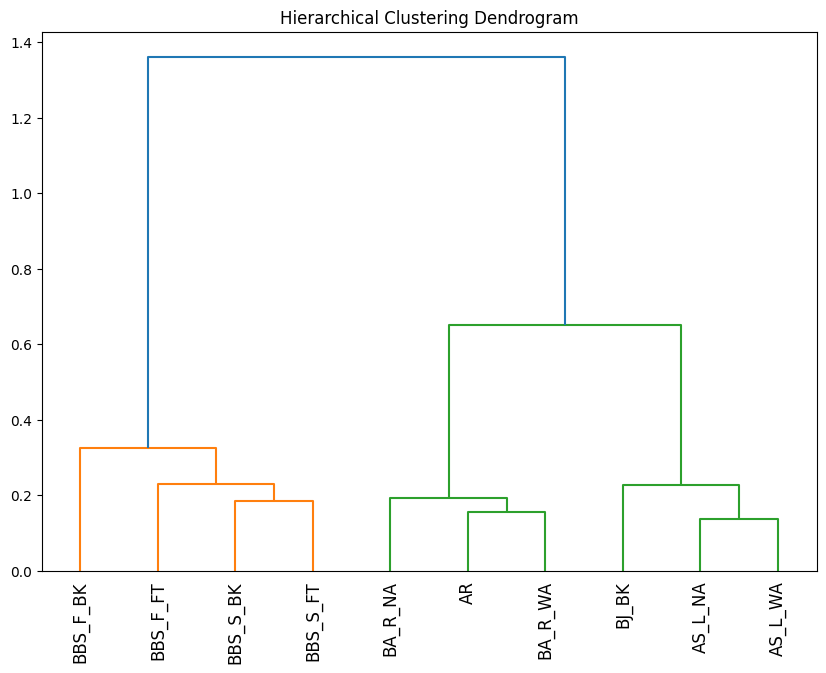

In [35]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=similarities.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

### Dendogram Nicoletta

Clusterings based on angle similarity of poses is much less able to discern the movement patterns!

In [ ]:
get_dendogram_angle()

In [ ]:
get_dendogram_velocity()